# ThinkBrake: Token Length Experiment

## Import and Configs

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from pathlib import Path
import seaborn as sns
from matplotlib.patches import Patch

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update(
    {
        "figure.figsize": (14, 7),
        "font.size": 11,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "figure.dpi": 100,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "font.family": "sans-serif",
    }
)

model_colors = sns.color_palette("dark", 8)
benchmark_colors = sns.color_palette("dark", 10)
method_palette = {
    "Baseline": "#2C3E50",
    "Thinkless": "#E74C3C",
    "ThinkBrake": "#3498DB",
}
threshold_palette = sns.color_palette("Blues", 6)[1:]
bar_colors = [
    "#1A5276",
    "#2980B9",
    "#5499C7",
    "#7FB3D5",
    "#A9CCE3",
    "#F5B7B1",
    "#F1948A",
    "#EC7063",
    "#E74C3C",
    "#B03A2E",
]
line_colors = [
    "#1A5276",
    "#B03A2E",
    "#1E8449",
    "#7D3C98",
    "#B9770E",
    "#117A65",
    "#6C3483",
    "#1F618D",
]

markers = ["o", "s", "^", "D", "v", "p", "h", "*"]

model_name_map = {}
short_names = {}

In [2]:
def calc_subplot_layout(n_items, max_cols=4):
    if n_items == 0:
        return 1, 1, (6, 4)

    cols = min(n_items, max_cols)
    rows = math.ceil(n_items / cols)
    fig_width = 5.5 * cols
    fig_height = 4.5 * rows
    return rows, cols, (fig_width, fig_height)


def create_dynamic_subplots(n_items, max_cols=4, sharey=False):
    rows, cols, figsize = calc_subplot_layout(n_items, max_cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, sharey=sharey)

    if n_items == 1:
        axes = np.array([axes])
    else:
        axes = np.array(axes).flatten()

    for i in range(n_items, len(axes)):
        axes[i].set_visible(False)

    return fig, axes


def add_value_labels(ax, bars, fmt=".1f", rotation=0, fontsize=9, offset=0.5):
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.annotate(
                f"{height:{fmt}}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, offset),
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=fontsize,
                rotation=rotation,
            )


def format_model_name(name, short_names):
    return short_names.get(name, name.split("/")[-1])


def load_detailed_results(model_dir, benchmark, method="rollout"):
    base_path = Path(f"../output/{model_dir}")
    math_benchmarks = ["gsm8k", "math500", "aime2024", "aime2025"]
    general_benchmarks = ["gpqa-diamond", "arc-challenge"]

    if benchmark in math_benchmarks:
        category = "math"
    elif benchmark in general_benchmarks:
        category = "general"
    else:
        return None

    if method == "rollout":
        file_path = base_path / category / "rollout" / f"{benchmark}_result.jsonl"
    else:
        file_path = (
            base_path / category / "thinkbrake" / method / f"{benchmark}_result.jsonl"
        )

    if not file_path.exists():
        return None

    results = []
    with open(file_path, "r") as f:
        for line in f:
            if line.strip():
                results.append(json.loads(line))
    return results

## Load Dataset

In [3]:
INCLUDE_MODELS = [
    "Qwen_Qwen3-4B-Thinking-2507",
    "Qwen_Qwen3-4B",
    "Qwen_Qwen3-14B",
    "Qwen_Qwen3-32B",
    "deepseek-ai_DeepSeek-R1-Distill-Qwen-7B",
    "microsoft_phi-4-reasoning",
]

INCLUDE_BENCHMARKS = [
    "gsm8k",
    "math500",
    "aime2024",
    "aime2025",
    "gpqa-diamond",
    # "arc-challenge",
    # "bfcl-v1",
    # "bfcl-v2",
    # "meta-tool",
]

INCLUDE_THRESHOLDS = [
    "0.1",
    "0.25",
    "1.0",
    "2.5",
]

BEST_THRESHOLD = 0.1

In [4]:
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
METRICS_PATH = PROJECT_ROOT / "metrics_summary.jsonl"

rows = []
with open(METRICS_PATH, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        rows.append(json.loads(line))

df_metrics = pd.DataFrame(rows)
df_metrics = df_metrics[df_metrics["sub_category"].isna()].copy()
df_metrics = df_metrics[df_metrics["model"].isin(INCLUDE_MODELS)].copy()
df_metrics = df_metrics[df_metrics["benchmark"].isin(INCLUDE_BENCHMARKS)].copy()

benchmarks = INCLUDE_BENCHMARKS
thresholds = sorted(INCLUDE_THRESHOLDS, key=lambda x: float(x))


def _model_key(model_dir: str) -> str:
    return model_name_map.get(model_dir, model_dir)


rollout_data = {}
thinkbrake_data = {}

df_rollout = df_metrics[
    (df_metrics["method"] == "rollout") & (df_metrics["threshold"].isna())
]
for _, r in df_rollout.iterrows():
    mk = _model_key(r["model"])
    rollout_data.setdefault(mk, {})
    rollout_data[mk][r["benchmark"]] = {
        "accuracy": float(r.get("accuracy", 0.0) or 0.0),
        "avg_token_length": float(r.get("avg_token_length", 0.0) or 0.0),
    }

df_tb = df_metrics[
    (df_metrics["method"] == "thinkbrake") & (~df_metrics["threshold"].isna())
]
for _, r in df_tb.iterrows():
    mk = _model_key(r["model"])
    try:
        t = float(r["threshold"])
    except Exception:
        continue
    t_str = str(t)
    if t_str not in INCLUDE_THRESHOLDS:
        continue
    thinkbrake_data.setdefault(mk, {})
    thinkbrake_data[mk].setdefault(r["benchmark"], {})
    thinkbrake_data[mk][r["benchmark"]][f"threshold_{t_str}"] = {
        "accuracy": float(r.get("accuracy", 0.0) or 0.0),
        "avg_token_length": float(r.get("avg_token_length", 0.0) or 0.0),
    }

filtered_rollout_data = {
    k: v
    for k, v in rollout_data.items()
    if k in [model_name_map.get(m, m) for m in INCLUDE_MODELS]
}
filtered_thinkbrake_data = {
    k: v
    for k, v in thinkbrake_data.items()
    if k in [model_name_map.get(m, m) for m in INCLUDE_MODELS]
}
baseline_data = filtered_rollout_data

print("Data loaded successfully!")

Data loaded successfully!


## Token Length Distribution Analysis

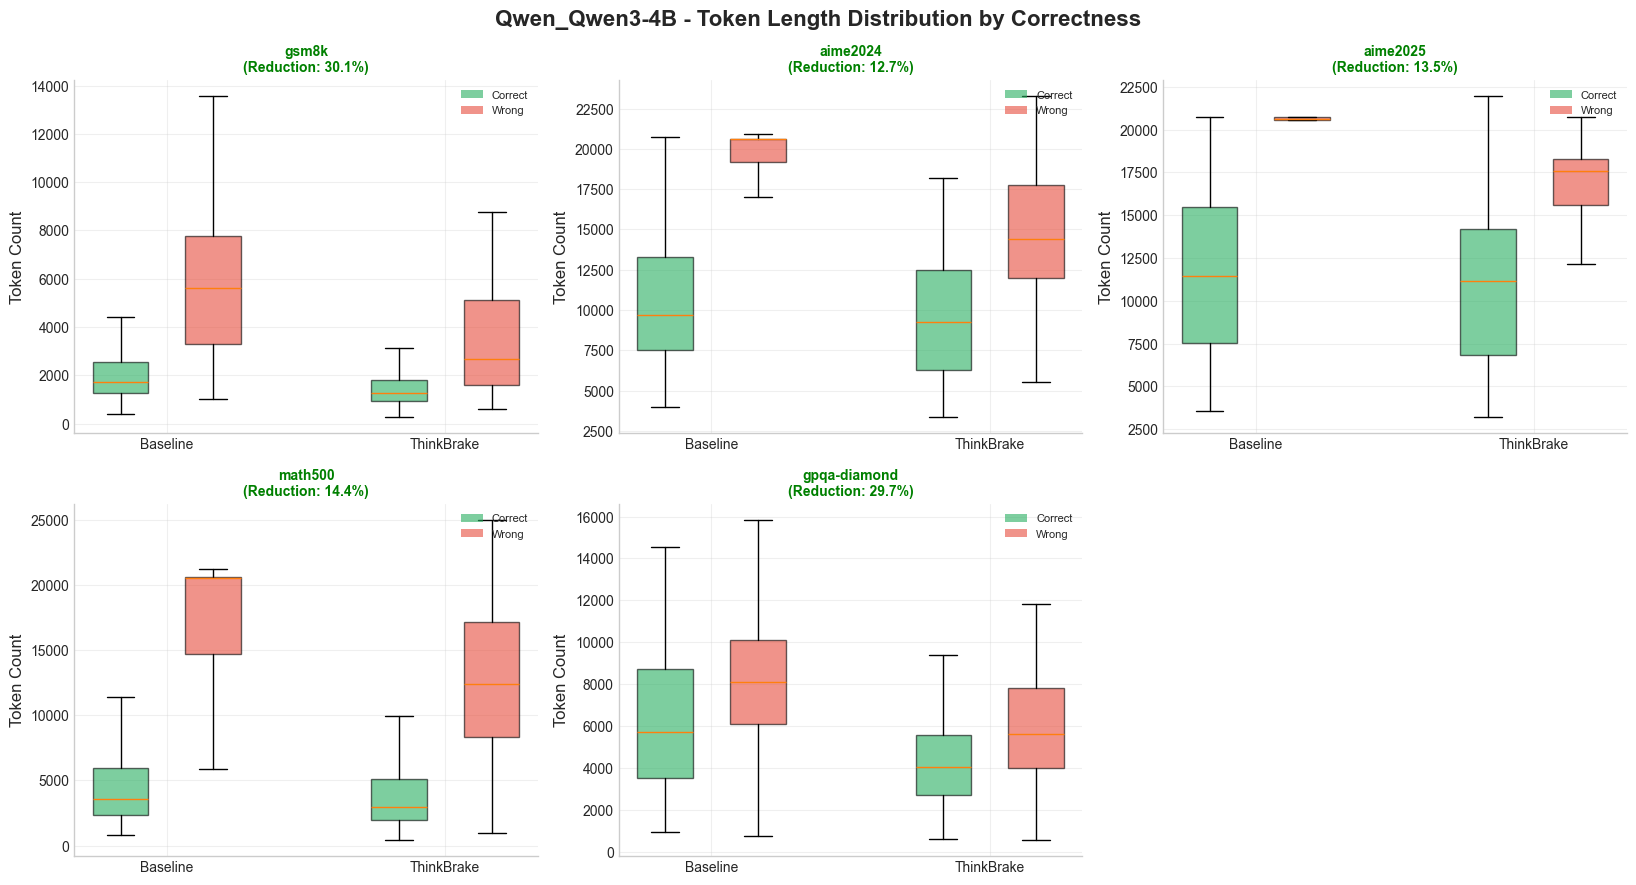

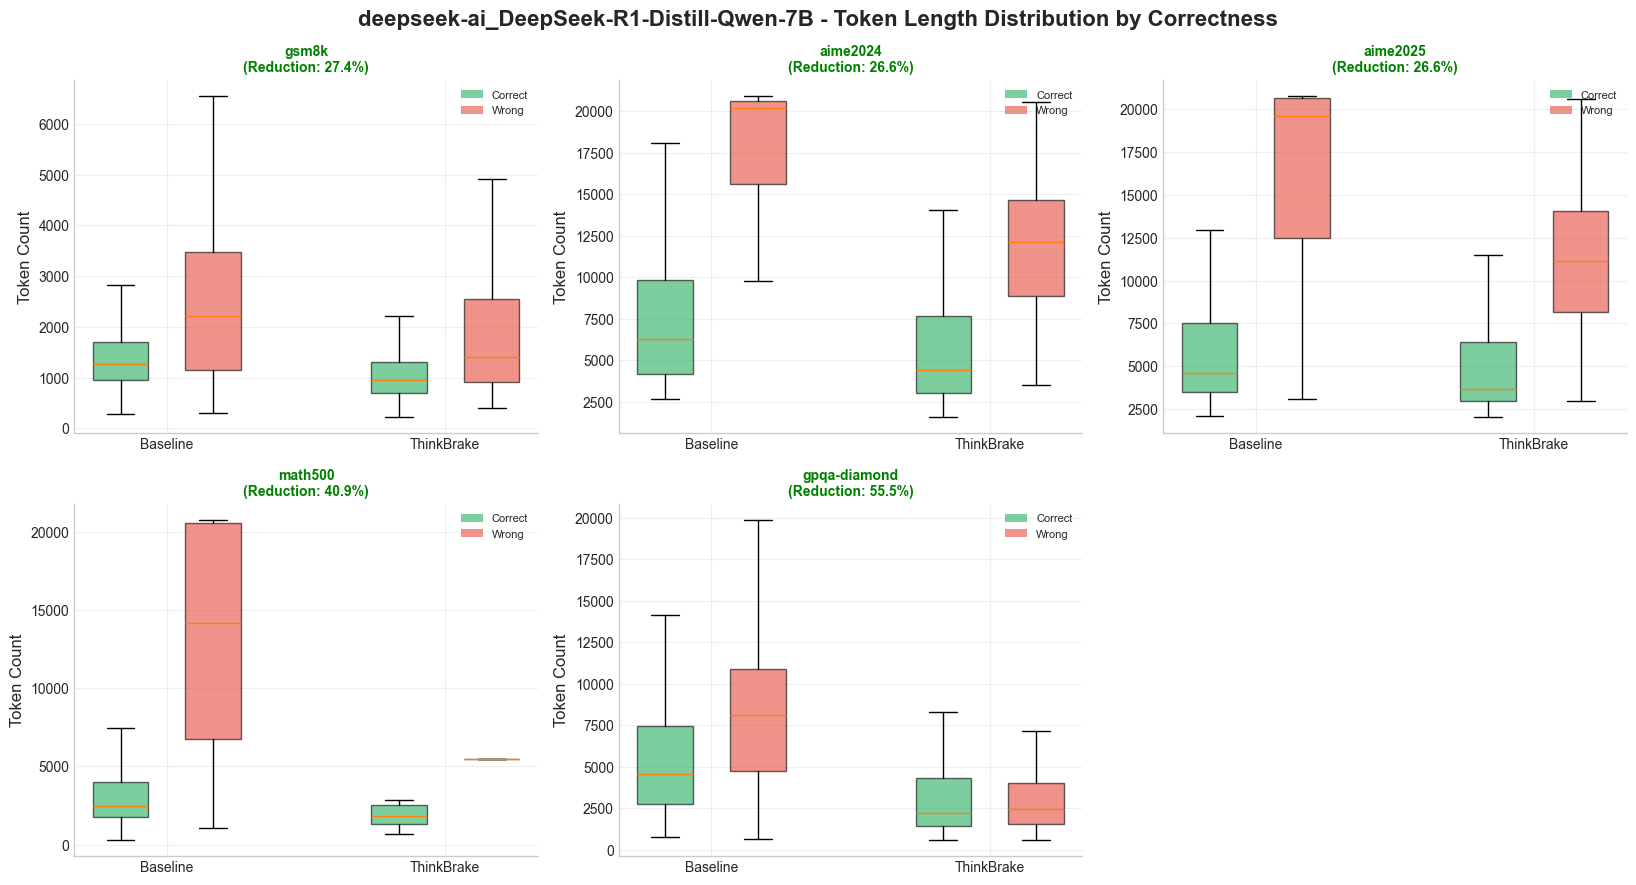

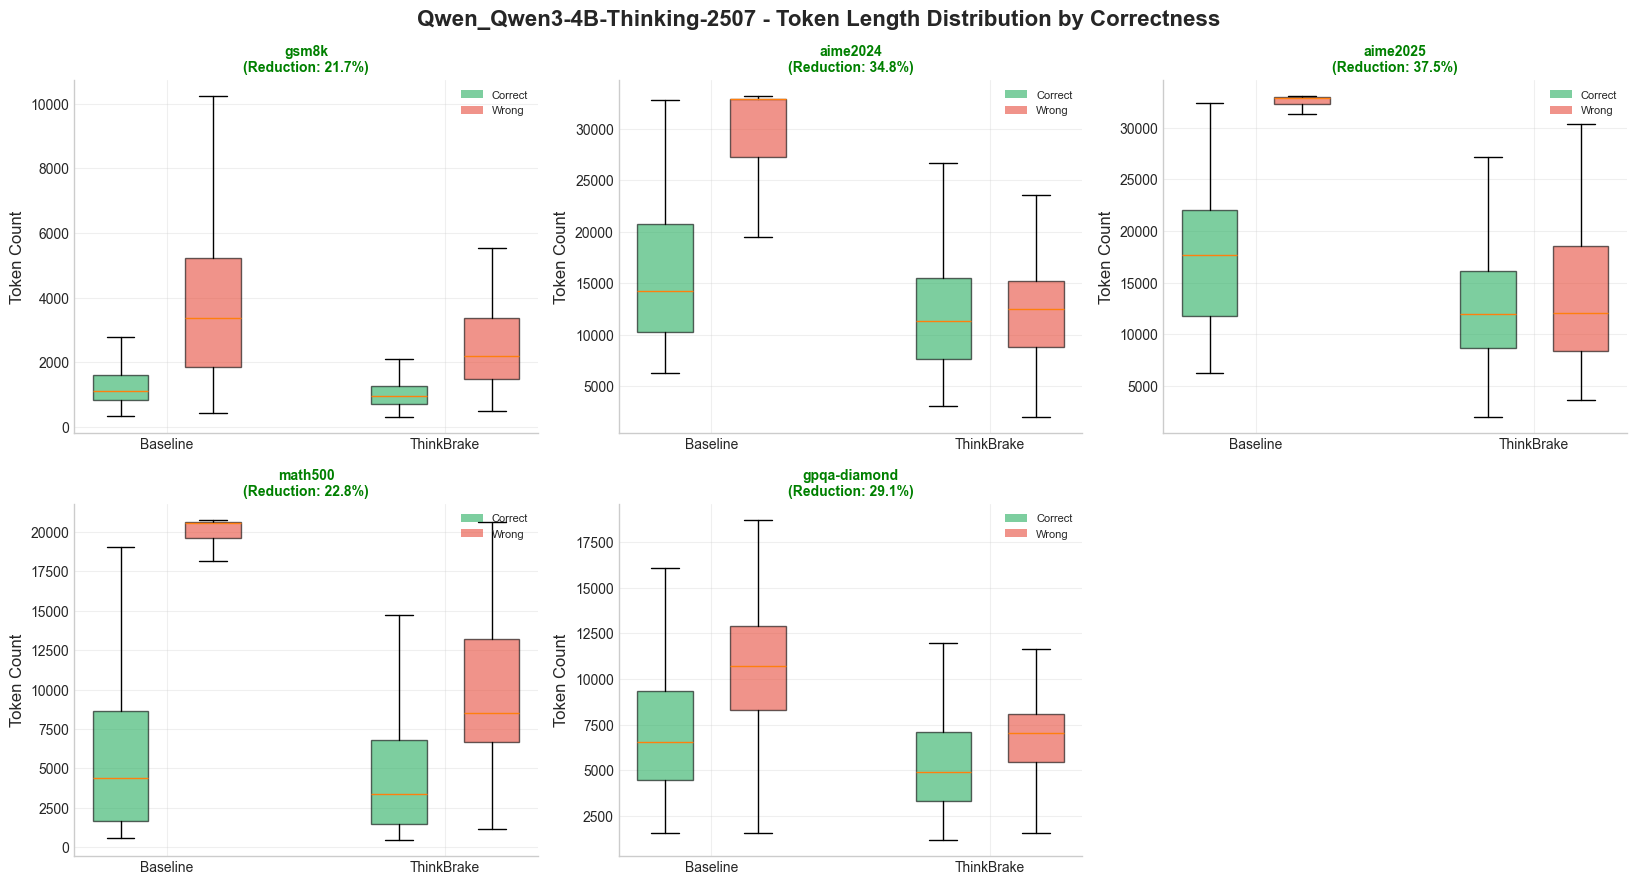

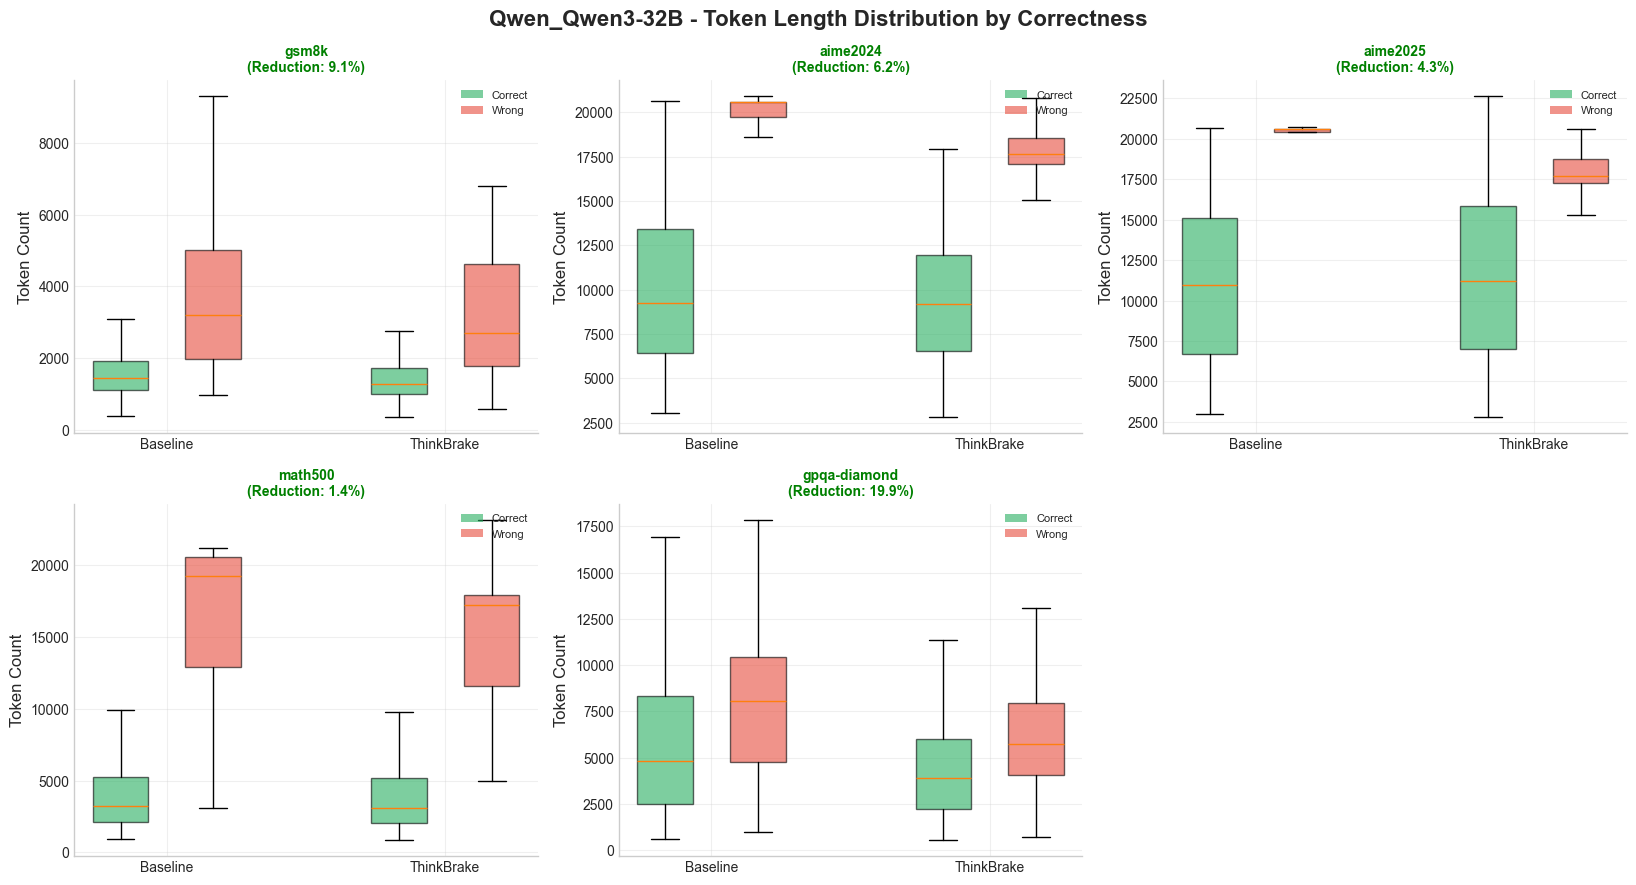

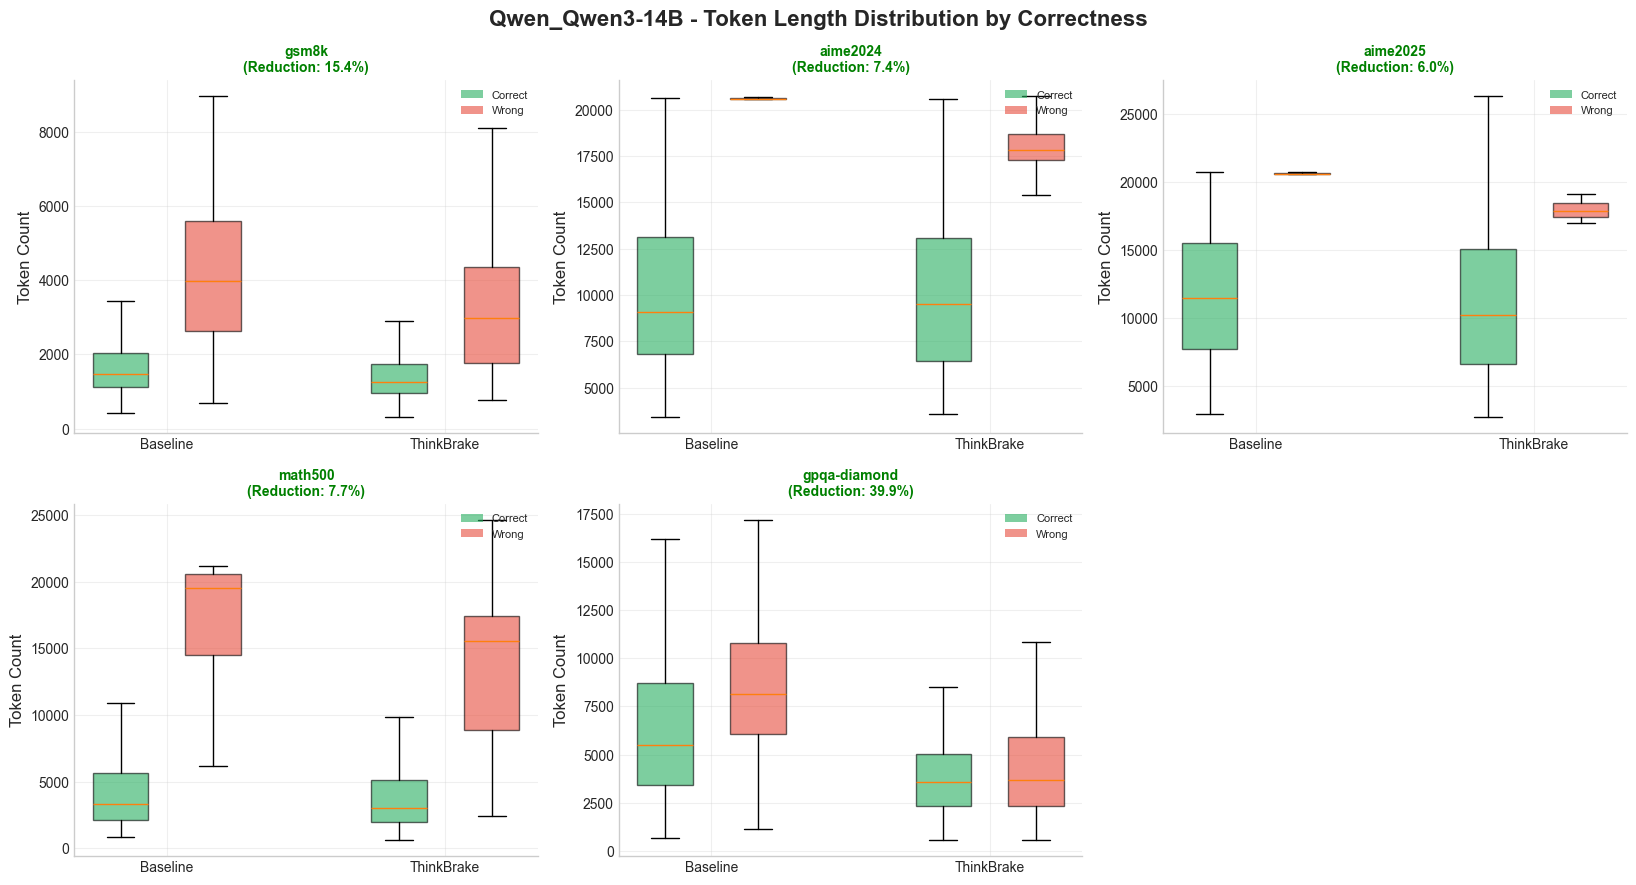

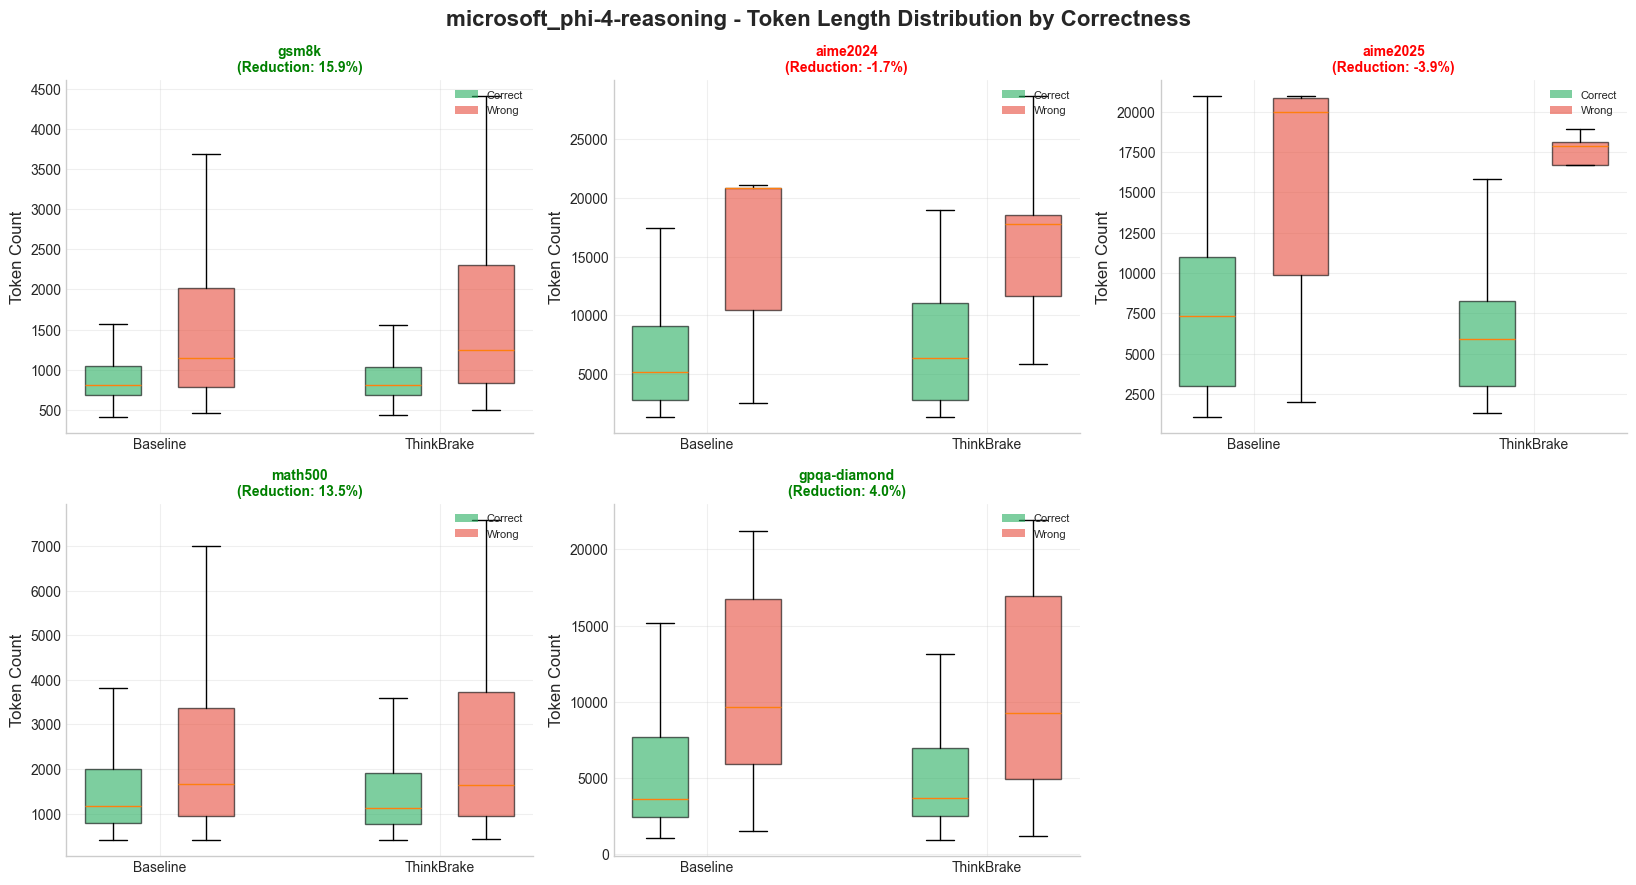

In [5]:
if "df_tokens" not in globals():
    scored_path = (
        (PROJECT_ROOT / "scored_results.csv")
        if "PROJECT_ROOT" in globals()
        else Path("../scored_results.csv")
    )
    if not scored_path.exists():
        raise FileNotFoundError(f"Missing scored results: {scored_path}")

    df_scored = pd.read_csv(
        scored_path,
        usecols=[
            "model",
            "method",
            "threshold",
            "benchmark",
            "is_correct",
            "token_count",
        ],
    )

    if "INCLUDE_MODELS" in globals():
        df_scored = df_scored[df_scored["model"].isin(INCLUDE_MODELS)]
    if "INCLUDE_BENCHMARKS" in globals():
        df_scored = df_scored[df_scored["benchmark"].isin(INCLUDE_BENCHMARKS)]

    # Baseline (rollout)
    df_base = df_scored[df_scored["method"] == "rollout"].copy()
    df_base["method"] = "Baseline"

    # ThinkBrake at BEST_THRESHOLD
    if "BEST_THRESHOLD" not in globals():
        raise NameError("BEST_THRESHOLD is not defined")
    thr = pd.to_numeric(df_scored["threshold"], errors="coerce")
    mask_tb = (
        (df_scored["method"] == "thinkbrake")
        & thr.notna()
        & np.isclose(thr, BEST_THRESHOLD)
    )
    df_tb = df_scored[mask_tb].copy()
    df_tb["method"] = f"ThinkBrake (t={BEST_THRESHOLD})"

    df_tokens = pd.concat([df_base, df_tb], ignore_index=True)
    df_tokens = df_tokens.rename(
        columns={"is_correct": "correct", "token_count": "tokens"}
    )
    df_tokens["correct"] = df_tokens["correct"].astype(bool)
    df_tokens["tokens"] = pd.to_numeric(df_tokens["tokens"], errors="coerce")
    df_tokens = df_tokens.dropna(subset=["tokens"])

available_models = df_tokens["model"].unique()

for model in available_models:
    model_data = df_tokens[df_tokens["model"] == model]
    benchmarks_in_model = model_data["benchmark"].unique()
    n_benchmarks = len(benchmarks_in_model)

    if n_benchmarks == 0:
        continue

    fig, axes = create_dynamic_subplots(n_benchmarks, max_cols=3)

    for idx, benchmark in enumerate(benchmarks_in_model):
        ax = axes[idx]
        bench_data = model_data[model_data["benchmark"] == benchmark]

        # Box plot by correctness
        baseline_correct = bench_data[
            (bench_data["method"] == "Baseline") & (bench_data["correct"])
        ]["tokens"]
        baseline_wrong = bench_data[
            (bench_data["method"] == "Baseline") & (~bench_data["correct"])
        ]["tokens"]
        tb_correct = bench_data[
            (bench_data["method"] == f"ThinkBrake (t={BEST_THRESHOLD})")
            & (bench_data["correct"])
        ]["tokens"]
        tb_wrong = bench_data[
            (bench_data["method"] == f"ThinkBrake (t={BEST_THRESHOLD})")
            & (~bench_data["correct"])
        ]["tokens"]

        data_to_plot = [baseline_correct, baseline_wrong, tb_correct, tb_wrong]
        positions = [0, 1, 3, 4]
        colors_box = ["#27AE60", "#E74C3C", "#27AE60", "#E74C3C"]

        # showfliers=False to hide outliers
        bp = ax.boxplot(
            data_to_plot,
            positions=positions,
            patch_artist=True,
            widths=0.6,
            showfliers=False,
        )

        for patch, color in zip(bp["boxes"], colors_box):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)

        ax.set_xticks([0.5, 3.5])
        ax.set_xticklabels(["Baseline", "ThinkBrake"])
        ax.set_ylabel("Token Count")

        # Add reduction stats
        baseline_mean = bench_data[bench_data["method"] == "Baseline"]["tokens"].mean()
        tb_mean = bench_data[
            bench_data["method"] == f"ThinkBrake (t={BEST_THRESHOLD})"
        ]["tokens"].mean()
        reduction = (1 - tb_mean / baseline_mean) * 100 if baseline_mean > 0 else 0

        ax.set_title(
            f"{benchmark}\n(Reduction: {reduction:.1f}%)",
            fontsize=10,
            fontweight="bold",
            color="green" if reduction > 0 else "red",
        )

        # Add legend
        legend_elements = [
            Patch(facecolor="#27AE60", alpha=0.6, label="Correct"),
            Patch(facecolor="#E74C3C", alpha=0.6, label="Wrong"),
        ]
        ax.legend(handles=legend_elements, loc="upper right", fontsize=8)

        ax.grid(True, alpha=0.3)

    display_name = short_names.get(model_name_map.get(model, model), model)
    fig.suptitle(
        f"{display_name} - Token Length Distribution by Correctness",
        fontsize=16,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.show()